# Train MobilenetV2 and Save to OpenMV

This Code is for TensorFlow 2

## Download Cats vs Dogs dataset from github


In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras, lite
from tensorflow.keras import layers, Sequential

CLASS_NUM = 4 # dog and cat
INPUT_SIZE = 96 #image size is 96 * 96 *3
EPOCHS = 10
LEARNING = 0.0001

In [2]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input, validation_split=0.3)

test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

training_set = train_datagen.flow_from_directory('Dataset/Training',
                                                 target_size = (INPUT_SIZE, INPUT_SIZE),
                                                 subset='training',
                                                 batch_size = 32)

validation_set = train_datagen.flow_from_directory('Dataset/Training',
                                                 target_size = (INPUT_SIZE, INPUT_SIZE),
                                                 subset='validation',
                                                 batch_size = 32)

test_set = test_datagen.flow_from_directory('Dataset/Testing',
                                            target_size = (INPUT_SIZE, INPUT_SIZE),
                                            batch_size = 32)

Found 1400 images belonging to 4 classes.
Found 600 images belonging to 4 classes.
Found 40 images belonging to 4 classes.


## Define Model

alpha=0.35 for lower size

Note: Do NOT use GlobalAveragePooling2D Which is NOT supported by OpenMV

In [3]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
base = keras.applications.MobileNetV2(
    include_top=False,
    # alpha=0.35,
    weights="imagenet",
    input_shape=(INPUT_SIZE, INPUT_SIZE, 3)
)
base.trainable = False

inputs = keras.Input(shape=(96,96,3))
x = preprocess_input(inputs)
x = base(x, training=False)
flatten = keras.layers.Flatten()(x)
predictions = keras.layers.Dense(CLASS_NUM, activation='softmax')(flatten)
model = keras.models.Model(inputs=inputs, outputs=predictions)

model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-06-23 20:41:59.543548: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-23 20:41:59.543666: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 96, 96, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 96, 96, 3)        0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                             

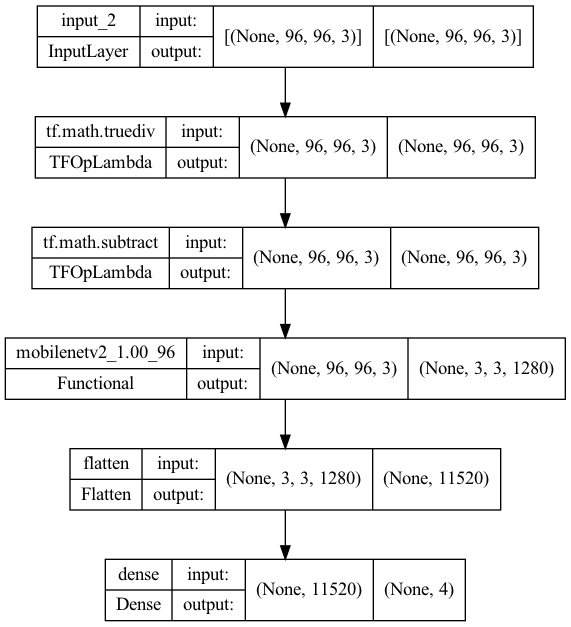

In [4]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Train model
After 1 epoches, accuracy is about 88% 

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(training_set, epochs = EPOCHS, validation_data = test_set)

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Full Integer Quantization

ref: https://www.tensorflow.org/lite/performance/post_training_quantization#full_integer_quantization

TODO: use real representative_dataset

In [ ]:
def representative_dataset():
    for _ in range(100):
        data = np.random.rand(1, INPUT_SIZE, INPUT_SIZE, 3)
        yield [data.astype(np.float32)]

# def representative_dataset():
#   for data in tf.data.Dataset.from_tensor_slices((images)).batch(1).take(100):
#     yield [tf.dtypes.cast(data, tf.float32)]

# Convert the tflite.
converter = lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()

# Save the model.
with open('trained_mobilenet.tflite', 'wb') as f:
  f.write(tflite_quant_model)

## Succeed

Copy trained.tflite to OpenMV4 H7 Plus